In [1]:
import numpy as np
from Patrol import OmniPatrol
from Simulator import Simulator
from shapely.geometry import Polygon, Point
from scipy.optimize import differential_evolution
from optimize import generate_bounds, generalized_objective
from Voronoi import create_voronoi_partitions_on_map, plot_results

In [2]:
SHAPE_CONFIG = {"Triangle": 3, "Square": 0, "Hexagon": 0}
S_R = 8.0
DE_WEIGHTS = [2.0, 1.0, 0.5, 1.0, 10.0]

SCALE = 2
SHIFT = (-5, -4)
MAP_VERTICES = (
    np.array(
        [
            (-2, 0),
            (11, 0),
            (11, -3),
            (14, -4),
            (17, -4),
            (20, -2.5),
            (20, 8),
            (17, 8),
            (17, 13),
            (13, 13),
            (13, 9),
            (4, 9),
            (4, 6),
            (-2, 6),
            (-2, 0),
        ]
    )
    * SCALE
    + SHIFT
)

C = 3e8
EMITTER_PARAMS = {"efficiency": 1.0, "pt": 30, "gain": 1.0, "wavelength": C / 2.4e9}

In [3]:
def random_point_in_polygon(polygon_vertices):
    poly = Polygon(polygon_vertices)
    minx, miny, maxx, maxy = poly.bounds

    while True:
        p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if poly.contains(p):
            return np.array([p.x, p.y])

In [4]:
def voronoi_cells(map_polygon):

    minx, miny, maxx, maxy = map_polygon.bounds
    x_coords = np.linspace(minx, maxx, 4)
    y_coords = np.linspace(miny, maxy, 4)

    xbound = (minx, maxx)
    ybound = (miny, maxy)

    grid_points_input = []
    for x in x_coords:
        for y in y_coords:
            grid_points_input.append((x, y))

    clipped_cells, used_sites = create_voronoi_partitions_on_map(
        map_polygon, grid_points_input
    )
    plot_results(map_polygon, clipped_cells, used_sites)

    return clipped_cells, xbound, ybound

In [5]:
def area_coverage_optimiser(cell, xbound, ybound):

    patrols = []
    bounds = generate_bounds(SHAPE_CONFIG, S_R, xbound, ybound)

    print("Optimizer Started")

    result = differential_evolution(
        generalized_objective,
        bounds,
        args=(S_R, DE_WEIGHTS, SHAPE_CONFIG, cell),
        maxiter=500,
        polish=True,
        init="halton",
        updating="deferred",
        workers=-1,
    )

    params = result.x

    print("Optimizer finished")

    idx = 0
    for shape, count in SHAPE_CONFIG.items():
        for _ in range(count):
            x = params[idx]
            y = params[idx + 1]
            angle = params[idx + 2]
            length = params[idx + 3]

            patrol = OmniPatrol(shape, (x, y), S_R, side=length, angle=angle)
            patrols.append(patrol)
            idx += 4

    return params, patrols

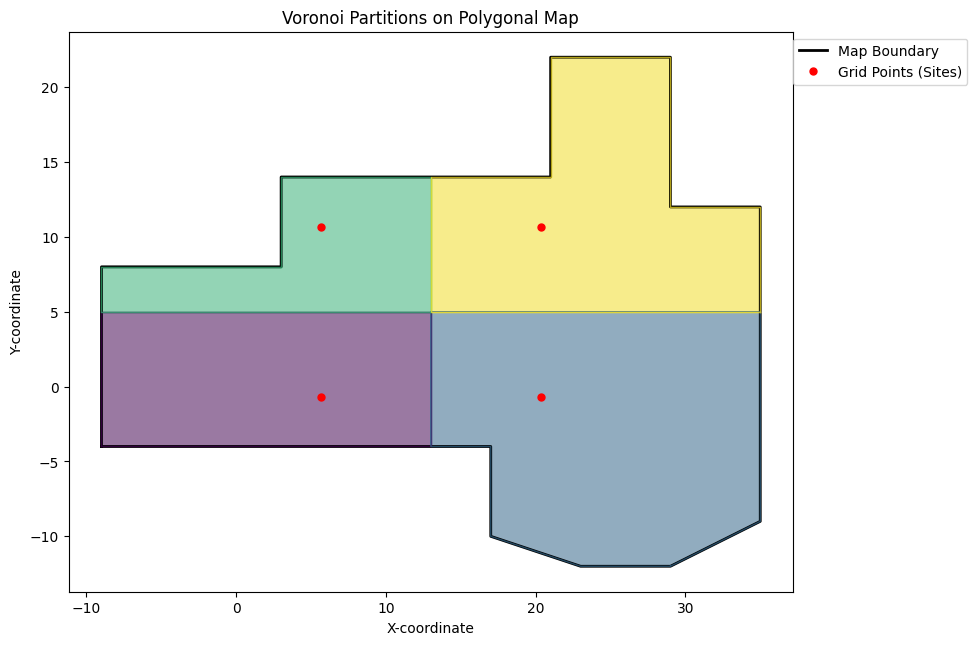

Cell 0
Optimizer Started


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Optimizer finished
Sim Started


KeyboardInterrupt: 

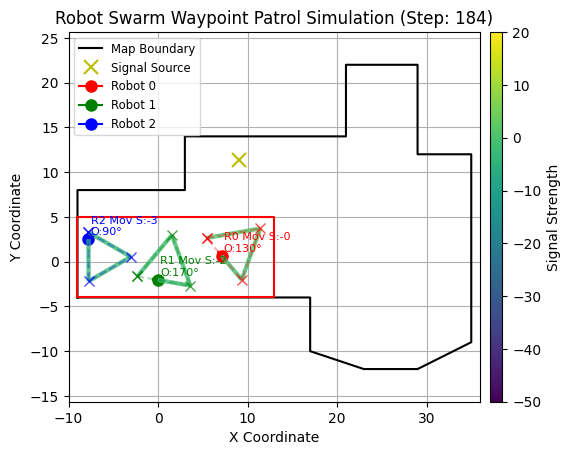

In [7]:
SIGNAL_SOURCE_POS = random_point_in_polygon(MAP_VERTICES)

map_polygon = Polygon(MAP_VERTICES)
cells, xbound, ybound = voronoi_cells(map_polygon)

params = {
    "sim_steps" : 500,
    "map_vertices" : MAP_VERTICES,
    "num_robots" : 3,
    "source" : {
        "pos" : SIGNAL_SOURCE_POS,
        "params" : EMITTER_PARAMS,
    }
}

simulator = Simulator(params, plotting=True, sleep_time=0.05)

for i, cell in enumerate(cells):
    
    print(f"Cell {i}")
    
    params, patrols = area_coverage_optimiser(cell, xbound, ybound)
    
    robot_waypoints = []
    for patrol in patrols:
        robot_waypoints.append(np.array(patrol.patrol.exterior.coords))
        
    sim_data = simulator.run({"cell_id" : i, "cell_polygon" : cell}, robot_waypoints)